# Phân Tích USDA Food Database: Dinh Dưỡng & Nhóm Thực Phẩm

## Lời Mở Đầu
Dự án này phân tích Cơ Sở Dữ Liệu Thực Phẩm của Bộ Nông nghiệp Hoa Kỳ (USDA) để:
- Khám phá hàm lượng dinh dưỡng của các loại thực phẩm
- Tạo cấu trúc dữ liệu cho phân tích theo nhóm thực phẩm
- Đánh giá tương quan giữa các chất dinh dưỡng
- Phát triển chỉ số dinh dưỡng cân bằng cho từng nhóm

### Câu Hỏi Nghiên Cứu:
1. **Thống Kê Mô Tả**: Năng lượng, protein, độ đa dạng theo nhóm
2. **So Sánh**: Protein/lipid giữa các nhóm, tỷ lệ Energy-to-Protein
3. **Tương Quan**: Energy vs Fat, Water content impact
4. **Dự Đoán**: Chỉ số dinh dưỡng cân bằng, khuyến nghị cá nhân

In [2]:
# Import thư viện cần thiết
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr, spearmanr
import warnings
warnings.filterwarnings('ignore')

# Cấu hình hiển thị
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("Thư viện đã import thành công!")

Thư viện đã import thành công!


In [3]:
# Tải dữ liệu USDA Food Database
db = json.load(open("datasets/usda_food/database.json"))

print(f"Tổng số loại thực phẩm: {len(db)}")
print(f"\nCác trường dữ liệu trong bản ghi đầu tiên:")
print(db[0].keys())

Tổng số loại thực phẩm: 6636

Các trường dữ liệu trong bản ghi đầu tiên:
dict_keys(['id', 'description', 'tags', 'manufacturer', 'group', 'portions', 'nutrients'])


In [5]:
# Bước 1: Tạo DataFrame thông tin thực phẩm
info_keys = ["description", "group", "id", "manufacturer"]
info = pd.DataFrame(db, columns=info_keys)

# Bước 2: Tạo DataFrame chất dinh dưỡng
nutrients = []
for rec in db:
    fnuts = pd.DataFrame(rec["nutrients"])
    fnuts["id"] = rec["id"]
    nutrients.append(fnuts)
nutrients = pd.concat(nutrients, ignore_index=True)

# Loại bỏ dòng trùng lặp
nutrients = nutrients.drop_duplicates()

# In ra thông tin cơ bản về hai DataFrame
print(f"Số bản ghi thông tin thực phẩm: {len(info)}")
print(f"Số bản ghi chất dinh dưỡng: {len(nutrients)}")
print(f"\nCác cột trong nutrients: {nutrients.columns.tolist()}")

Số bản ghi thông tin thực phẩm: 6636
Số bản ghi chất dinh dưỡng: 375176

Các cột trong nutrients: ['value', 'units', 'description', 'group', 'id']


In [6]:
# Bước 3: Đổi tên cột để tránh confusing
col_mapping_info = {"description": "food", "group": "fgroup"}
info = info.rename(columns=col_mapping_info, copy=False)

col_mapping_nutrients = {"description": "nutrient", "group": "nutgroup"}
nutrients = nutrients.rename(columns=col_mapping_nutrients, copy=False)

# Bước 4: Ghép hai DataFrame
ndata = pd.merge(nutrients, info, on="id")

print(f"\nKích thước dữ liệu hợp nhất: {ndata.shape}")
print(f"\nCác cột: {ndata.columns.tolist()}")
print(f"\nVí dụ dữ liệu:")
print(ndata.iloc[30000])


Kích thước dữ liệu hợp nhất: (375176, 8)

Các cột: ['value', 'units', 'nutrient', 'nutgroup', 'id', 'food', 'fgroup', 'manufacturer']

Ví dụ dữ liệu:
value                                             0.04
units                                                g
nutrient                                       Glycine
nutgroup                                   Amino Acids
id                                                6158
food            Soup, tomato bisque, canned, condensed
fgroup                      Soups, Sauces, and Gravies
manufacturer                                          
Name: 30000, dtype: object


---

# Phần 1: Thống Kê Mô Tả - Khám Phá Dinh Dưỡng

## 1.1 - Năng Lượng Trung Bình theo Nhóm Thực Phẩm

**Câu hỏi**: Trung bình năng lượng (kcal) của từng nhóm thực phẩm là bao nhiêu?

In [7]:
# Lọc dữ liệu năng lượng
energy_data = ndata[ndata['nutrient'] == 'Energy'].copy()

# Tính năng lượng trung bình theo nhóm
energy_by_group = energy_data.groupby('fgroup')['value'].agg([
    ('mean', 'mean'),
    ('median', 'median'),
    ('std', 'std'),
    ('min', 'min'),
    ('max', 'max'),
    ('count', 'count')
]).round(2)

energy_by_group = energy_by_group.sort_values('mean', ascending=False)

print("Năng Lượng (kcal) Trung Bình theo Nhóm Thực Phẩm:")
print(energy_by_group)
print(f"\nNhóm có năng lượng cao nhất: {energy_by_group.index[0]} ({energy_by_group['mean'].iloc[0]:.2f} kcal)")
print(f"Nhóm có năng lượng thấp nhất: {energy_by_group.index[-1]} ({energy_by_group['mean'].iloc[-1]:.2f} kcal)")

Năng Lượng (kcal) Trung Bình theo Nhóm Thực Phẩm:
                                      mean  median      std    min     max  \
fgroup                                                                       
Fats and Oils                      1460.97   884.0  1286.90   15.0  3774.0   
Nut and Seed Products              1270.31   706.5   945.06   19.0  3008.0   
Snacks                             1152.15   820.0   736.74  253.0  2440.0   
Baked Products                      931.93   533.0   637.79    0.0  2335.0   
Sweets                              843.15   502.0   706.18   11.0  2504.0   
Breakfast Cereals                   824.92   400.0   624.17   42.0  2046.0   
Cereal Grains and Pasta             739.04   387.0   568.58   40.0  2205.0   
Spices and Herbs                    660.67   368.5   542.69   19.0  1805.0   
Fast Foods                          647.98   394.5   471.00   16.0  2678.0   
Sausages and Luncheon Meats         611.95   397.5   480.82   79.0  2165.0   
Restaurant Foo

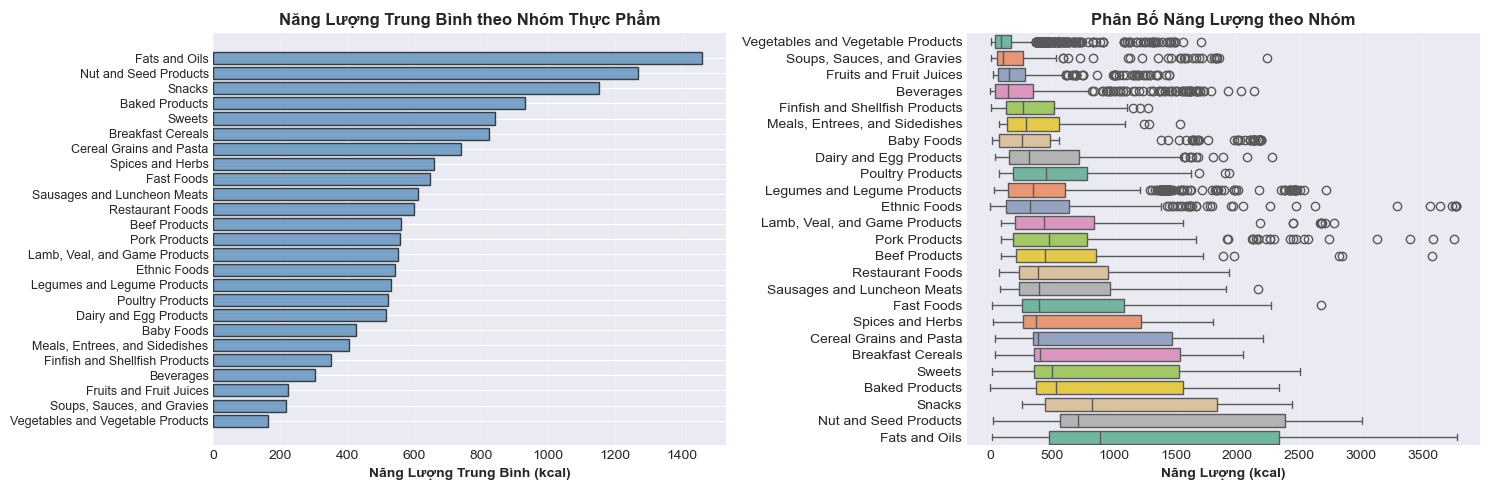

In [8]:
# Biểu đồ năng lượng theo nhóm
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Biểu đồ 1: Cột năng lượng trung bình
energy_by_group_sorted = energy_by_group.sort_values('mean')
axes[0].barh(range(len(energy_by_group_sorted)), energy_by_group_sorted['mean'].values, 
              color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_yticks(range(len(energy_by_group_sorted)))
axes[0].set_yticklabels(energy_by_group_sorted.index, fontsize=9)
axes[0].set_xlabel('Năng Lượng Trung Bình (kcal)', fontweight='bold')
axes[0].set_title('Năng Lượng Trung Bình theo Nhóm Thực Phẩm', fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')

# Biểu đồ 2: Box plot năng lượng
energy_data_sorted = energy_data.copy()
energy_data_sorted['fgroup'] = pd.Categorical(energy_data_sorted['fgroup'], 
                                               categories=energy_by_group_sorted.index, 
                                               ordered=True)
sns.boxplot(data=energy_data_sorted, y='fgroup', x='value', ax=axes[1], palette='Set2')
axes[1].set_xlabel('Năng Lượng (kcal)', fontweight='bold')
axes[1].set_ylabel('')
axes[1].set_title('Phân Bố Năng Lượng theo Nhóm', fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('energy_by_group.png', dpi=100, bbox_inches='tight')
plt.show()

## 1.2 - Loại Thực Phẩm Chứa Protein Cao Nhất

**Câu hỏi**: Loại thực phẩm nào chứa protein cao nhất trong nhóm "Dairy and Egg Products"?

In [9]:
# Lọc dữ liệu protein
protein_data = ndata[ndata['nutrient'] == 'Protein'].copy()

# Tìm thực phẩm có protein cao nhất trong mỗi nhóm
def find_highest_nutrient(group_data, group_name):
    """
    Tìm thực phẩm có hàm lượng chất dinh dưỡng cao nhất trong một nhóm
    """
    subset = protein_data[protein_data['fgroup'] == group_name].copy()
    if subset.empty:
        return None
    
    highest_idx = subset['value'].idxmax()
    return subset.loc[highest_idx]

# Tìm protein cao nhất cho từng nhóm
protein_by_group = []
for group in ndata['fgroup'].unique():
    record = find_highest_nutrient(protein_data, group)
    if record is not None:
        protein_by_group.append({
            'Nhóm': group,
            'Thực Phẩm': record['food'][:60],
            'Protein (g)': record['value']
        })

protein_df = pd.DataFrame(protein_by_group).sort_values('Protein (g)', ascending=False)

print("\nThực Phẩm Có Protein Cao Nhất trong Mỗi Nhóm:")
print(protein_df.to_string(index=False))

# Tập trung vào Dairy and Egg Products
dairy_protein = protein_data[protein_data['fgroup'] == 'Dairy and Egg Products'].copy()
if not dairy_protein.empty:
    top_dairy = dairy_protein.nlargest(10, 'value')
    print("\n\nTop 10 Thực Phẩm Có Protein Cao Nhất trong Nhóm Dairy and Egg Products:")
    print(top_dairy[['food', 'value']].to_string(index=False))


Thực Phẩm Có Protein Cao Nhất trong Mỗi Nhóm:
                             Nhóm                                                    Thực Phẩm  Protein (g)
      Legumes and Legume Products     Soy protein isolate, potassium type, crude protein basis        88.32
                           Sweets                            Gelatins, dry powder, unsweetened        85.60
                     Ethnic Foods          Seal, bearded (Oogruk), meat, dried (Alaska Native)        82.60
          Cereal Grains and Pasta                                           Vital wheat gluten        75.16
   Finfish and Shellfish Products                        Fish, cod, Atlantic, dried and salted        62.82
                           Snacks                                    Snacks, pork skins, plain        61.30
Vegetables and Vegetable Products                                    Seaweed, spirulina, dried        57.47
            Nut and Seed Products                                 Seeds, sesame flour, lo

## 1.3 - Độ Đa Dạng Dinh Dưỡng theo Nhóm

**Câu hỏi**: Nhóm nào có độ đa dạng dinh dưỡng cao nhất (nhiều loại chất khác nhau)?

In [11]:
# Tính số lượng chất dinh dưỡng khác nhau trong mỗi nhóm
nutrient_diversity = ndata.groupby('fgroup').agg({
    'nutrient': 'nunique',  # số loại chất dinh dưỡng
    'food': 'nunique',       # số loại thực phẩm
    'value': ['mean', 'std']  # giá trị trung bình và độ lệch
}).round(2)

nutrient_diversity.columns = ['Num_Nutrients', 'Num_Foods', 'Avg_Value', 'Std_Value']
nutrient_diversity = nutrient_diversity.sort_values('Num_Nutrients', ascending=False)

print("\nĐộ Đa Dạng Dinh Dưỡng theo Nhóm Thực Phẩm:")
print(nutrient_diversity)




Độ Đa Dạng Dinh Dưỡng theo Nhóm Thực Phẩm:
                                   Num_Nutrients  Num_Foods  Avg_Value  \
fgroup                                                                   
Vegetables and Vegetable Products             94        812     104.91   
Sweets                                        93        341      59.83   
Dairy and Egg Products                        93        107      66.04   
Snacks                                        92        162      88.32   
Fats and Oils                                 92         97     143.29   
Baked Products                                91        496      64.87   
Legumes and Legume Products                   91        365      58.10   
Fruits and Fruit Juices                       91        328      27.84   
Nut and Seed Products                         91        128      72.32   
Ethnic Foods                                  90        165     119.31   
Restaurant Foods                              90         51      42.

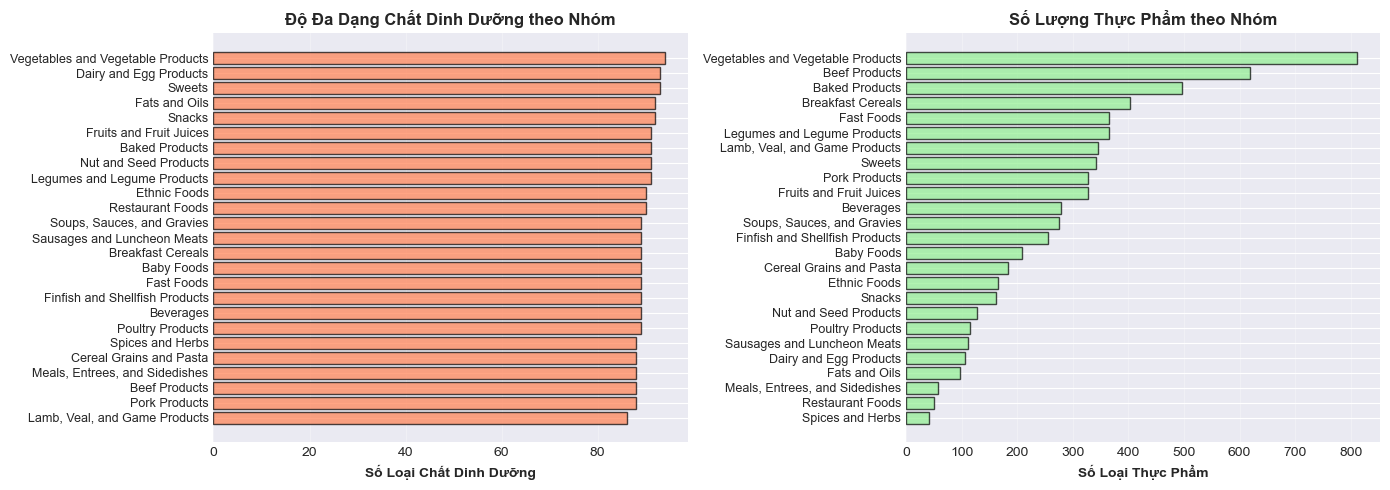

In [12]:
# Biểu đồ
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Biểu đồ 1: Số loại chất dinh dưỡng
nutrient_diversity_sorted = nutrient_diversity.sort_values('Num_Nutrients')
axes[0].barh(range(len(nutrient_diversity_sorted)), nutrient_diversity_sorted['Num_Nutrients'].values,
              color='coral', edgecolor='black', alpha=0.7)
axes[0].set_yticks(range(len(nutrient_diversity_sorted)))
axes[0].set_yticklabels(nutrient_diversity_sorted.index, fontsize=9)
axes[0].set_xlabel('Số Loại Chất Dinh Dưỡng', fontweight='bold')
axes[0].set_title('Độ Đa Dạng Chất Dinh Dưỡng theo Nhóm', fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')

# Biểu đồ 2: Số loại thực phẩm
nutrient_diversity_sorted2 = nutrient_diversity.sort_values('Num_Foods')
axes[1].barh(range(len(nutrient_diversity_sorted2)), nutrient_diversity_sorted2['Num_Foods'].values,
              color='lightgreen', edgecolor='black', alpha=0.7)
axes[1].set_yticks(range(len(nutrient_diversity_sorted2)))
axes[1].set_yticklabels(nutrient_diversity_sorted2.index, fontsize=9)
axes[1].set_xlabel('Số Loại Thực Phẩm', fontweight='bold')
axes[1].set_title('Số Lượng Thực Phẩm theo Nhóm', fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('nutrient_diversity.png', dpi=100, bbox_inches='tight')
plt.show()

---

# Phần 2: Phân Tích So Sánh - Tương Phản Giữa Các Nhóm

## 2.1 - So Sánh Protein và Lipid Giữa Các Nhóm

**Câu hỏi**: So sánh hàm lượng protein và lipid (chất béo) giữa nhóm "Meat" và "Dairy"?

In [13]:
# Chuẩn bị dữ liệu cho phân tích so sánh
# Lấy các chất dinh dưỡng chính: Protein, Fat, Carbohydrate, Energy
key_nutrients = ['Protein', 'Total lipid (fat)', 'Carbohydrate, by difference', 'Energy']

# Tạo pivot table: hàng = nhóm thực phẩm, cột = chất dinh dưỡng
comparison_data = ndata[ndata['nutrient'].isin(key_nutrients)].copy()

# Đưa về hình dạng phù hợp để so sánh
comparison_pivot = comparison_data.pivot_table(
    values='value',
    index=['fgroup', 'food'],
    columns='nutrient',
    aggfunc='mean'
)

# Tính trung bình theo nhóm
group_nutrition = ndata[ndata['nutrient'].isin(key_nutrients)].groupby(['fgroup', 'nutrient'])['value'].mean().unstack()

print("\nThành Phần Dinh Dưỡng Trung Bình theo Nhóm:")
print(group_nutrition.round(2))


Thành Phần Dinh Dưỡng Trung Bình theo Nhóm:
nutrient                           Carbohydrate, by difference   Energy  \
fgroup                                                                    
Baby Foods                                               22.13   426.39   
Baked Products                                           56.98   931.93   
Beef Products                                             0.07   559.32   
Beverages                                                21.30   303.88   
Breakfast Cereals                                        67.87   824.92   
Cereal Grains and Pasta                                  58.31   739.04   
Dairy and Egg Products                                   12.14   514.36   
Ethnic Foods                                             11.24   541.82   
Fast Foods                                               22.93   647.98   
Fats and Oils                                             8.11  1460.97   
Finfish and Shellfish Products                         

In [14]:
# So sánh cụ thể giữa Meat vs Dairy
meat_data = comparison_data[comparison_data['fgroup'].str.contains('Meat', case=False, na=False)]
dairy_data = comparison_data[comparison_data['fgroup'].str.contains('Dairy', case=False, na=False)]

if not meat_data.empty and not dairy_data.empty:
    meat_summary = meat_data.groupby('nutrient')['value'].agg(['mean', 'median', 'std'])
    dairy_summary = dairy_data.groupby('nutrient')['value'].agg(['mean', 'median', 'std'])
    
    print("\nMeat Products - Dinh Dưỡng:")
    print(meat_summary.round(2))
    
    print("\nDairy Products - Dinh Dưỡng:")
    print(dairy_summary.round(2))
    
    # Kiểm định t-test
    print("\nKiểm Định t-test (Meat vs Dairy):")
    for nutrient in key_nutrients:
        meat_vals = meat_data[meat_data['nutrient'] == nutrient]['value'].dropna()
        dairy_vals = dairy_data[dairy_data['nutrient'] == nutrient]['value'].dropna()
        
        if len(meat_vals) > 1 and len(dairy_vals) > 1:
            t_stat, p_value = stats.ttest_ind(meat_vals, dairy_vals)
            print(f"  {nutrient}: t={t_stat:.4f}, p={p_value:.4e}")


Meat Products - Dinh Dưỡng:
                               mean  median     std
nutrient                                           
Carbohydrate, by difference    3.40    2.60    2.98
Energy                       611.95  397.50  480.82
Protein                       15.86   15.00    4.70
Total lipid (fat)             17.53   18.17   11.28

Dairy Products - Dinh Dưỡng:
                               mean  median     std
nutrient                                           
Carbohydrate, by difference   12.14    5.36   15.60
Energy                       514.36  310.00  501.52
Protein                       14.22   12.40   11.00
Total lipid (fat)             10.32    6.00   10.41

Kiểm Định t-test (Meat vs Dairy):
  Protein: t=1.4447, p=1.5000e-01
  Total lipid (fat): t=4.9037, p=1.8475e-06
  Carbohydrate, by difference: t=-5.7970, p=2.3724e-08
  Energy: t=2.0746, p=3.8616e-02


## 2.2 - Tỷ Lệ Energy-to-Protein

**Câu hỏi**: Tỷ lệ Energy-to-Protein khác biệt thế nào giữa nhóm "Grains" và "Vegetables"?

In [15]:
# Tính tỷ lệ Energy-to-Protein
# Pivot để có Energy và Protein trong một DataFrame
pivot_nutrients = ndata[ndata['nutrient'].isin(['Energy', 'Protein'])].pivot_table(
    values='value',
    index=['fgroup', 'food'],
    columns='nutrient',
    aggfunc='mean'
)

# Tính tỷ lệ
pivot_nutrients['Energy_to_Protein'] = pivot_nutrients['Energy'] / (pivot_nutrients['Protein'] + 1)  # +1 để tránh chia cho 0

# Tính trung bình theo nhóm
energy_protein_ratio = pivot_nutrients.groupby(level='fgroup')[['Energy', 'Protein', 'Energy_to_Protein']].mean()
energy_protein_ratio = energy_protein_ratio.sort_values('Energy_to_Protein', ascending=False)

print("\nTỷ Lệ Energy-to-Protein theo Nhóm:")
print(energy_protein_ratio.round(2))

# So sánh Grains vs Vegetables
grains_data = pivot_nutrients.xs('Cereal Grains and Pasta', level='fgroup', drop_level=False) if 'Cereal Grains and Pasta' in pivot_nutrients.index.get_level_values('fgroup') else None
veg_data = pivot_nutrients.xs('Vegetables and Vegetable Products', level='fgroup', drop_level=False) if 'Vegetables and Vegetable Products' in pivot_nutrients.index.get_level_values('fgroup') else None

if grains_data is not None and len(grains_data) > 0:
    print(f"\nCereal Grains and Pasta - Energy/Protein: {grains_data['Energy_to_Protein'].mean():.2f}")
if veg_data is not None and len(veg_data) > 0:
    print(f"Vegetables - Energy/Protein: {veg_data['Energy_to_Protein'].mean():.2f}")


Tỷ Lệ Energy-to-Protein theo Nhóm:
nutrient                            Energy  Protein  Energy_to_Protein
fgroup                                                                
Fats and Oils                      1460.97     0.82            1265.38
Sweets                              843.15     4.34             303.06
Beverages                           303.88     1.34             178.38
Snacks                             1152.15     9.78             151.02
Baked Products                      931.93     6.73             138.25
Ethnic Foods                        541.82    16.00             129.21
Fruits and Fruit Juices             222.75     0.87             117.72
Nut and Seed Products              1270.31    14.86             108.15
Breakfast Cereals                   824.92     7.60             104.41
Cereal Grains and Pasta             739.04     9.11              89.42
Baby Foods                          426.39     4.23              78.30
Fast Foods                          647.9

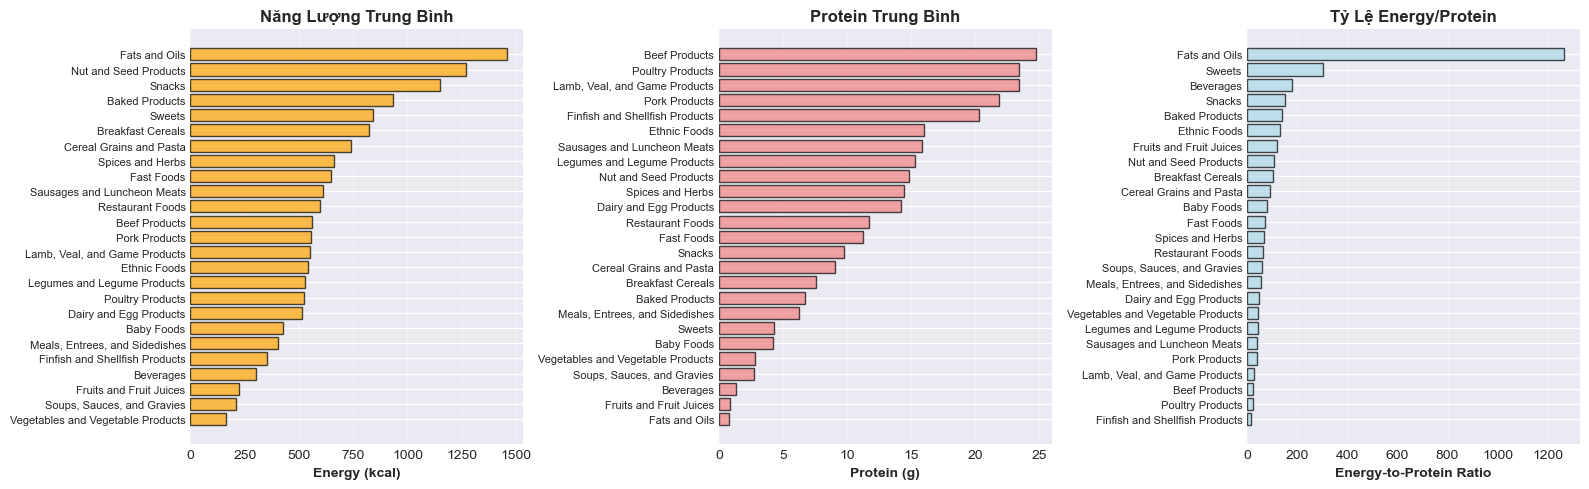

In [16]:
# Biểu đồ so sánh
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

energy_protein_sorted = energy_protein_ratio.sort_values('Energy')

# Biểu đồ 1: Energy
axes[0].barh(range(len(energy_protein_sorted)), energy_protein_sorted['Energy'].values,
              color='orange', edgecolor='black', alpha=0.7)
axes[0].set_yticks(range(len(energy_protein_sorted)))
axes[0].set_yticklabels(energy_protein_sorted.index, fontsize=8)
axes[0].set_xlabel('Energy (kcal)', fontweight='bold')
axes[0].set_title('Năng Lượng Trung Bình', fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')

# Biểu đồ 2: Protein
energy_protein_sorted2 = energy_protein_ratio.sort_values('Protein')
axes[1].barh(range(len(energy_protein_sorted2)), energy_protein_sorted2['Protein'].values,
              color='lightcoral', edgecolor='black', alpha=0.7)
axes[1].set_yticks(range(len(energy_protein_sorted2)))
axes[1].set_yticklabels(energy_protein_sorted2.index, fontsize=8)
axes[1].set_xlabel('Protein (g)', fontweight='bold')
axes[1].set_title('Protein Trung Bình', fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

# Biểu đồ 3: Energy-to-Protein Ratio
energy_protein_sorted3 = energy_protein_ratio.sort_values('Energy_to_Protein')
axes[2].barh(range(len(energy_protein_sorted3)), energy_protein_sorted3['Energy_to_Protein'].values,
              color='lightblue', edgecolor='black', alpha=0.7)
axes[2].set_yticks(range(len(energy_protein_sorted3)))
axes[2].set_yticklabels(energy_protein_sorted3.index, fontsize=8)
axes[2].set_xlabel('Energy-to-Protein Ratio', fontweight='bold')
axes[2].set_title('Tỷ Lệ Energy/Protein', fontweight='bold')
axes[2].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('energy_protein_comparison.png', dpi=100, bbox_inches='tight')
plt.show()

---

# Phần 3: Phân Tích Tương Quan - Mối Liên Hệ Giữa Chất Dinh Dưỡng

## 3.1 - Tương Quan Giữa các Chất Dinh Dưỡng

**Câu hỏi**: Có mối tương quan nào giữa năng lượng (Energy) và hàm lượng chất béo (Fat)?


Ma Trận Tương Quan Pearson giữa các Chất Dinh Dưỡng:
nutrient                     Carbohydrate, by difference  Energy  \
nutrient                                                           
Carbohydrate, by difference                        1.000   0.541   
Energy                                             0.541   1.000   
Fiber, total dietary                               0.450   0.242   
Protein                                           -0.284   0.200   
Total lipid (fat)                                 -0.048   0.768   
Water                                             -0.793  -0.912   

nutrient                     Fiber, total dietary  Protein  Total lipid (fat)  \
nutrient                                                                        
Carbohydrate, by difference                 0.450   -0.284             -0.048   
Energy                                      0.242    0.200              0.768   
Fiber, total dietary                        1.000   -0.053              0.002

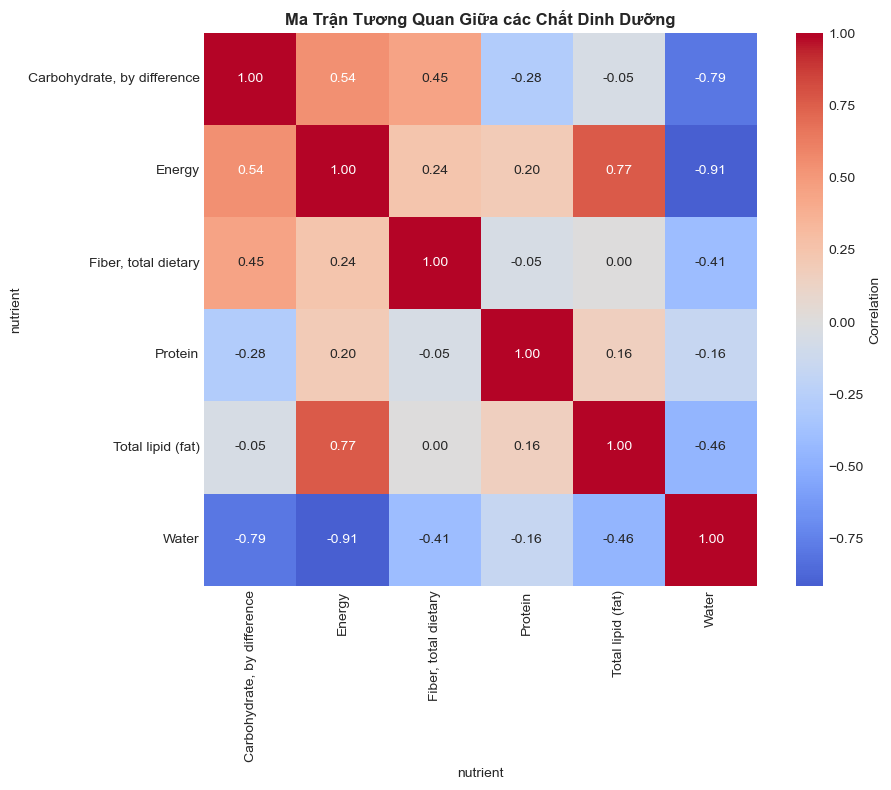

In [17]:
# Tạo ma trận tương quan
# Lọc các chất dinh dưỡng chính
main_nutrients = ['Energy', 'Protein', 'Total lipid (fat)', 'Carbohydrate, by difference', 'Fiber, total dietary', 'Water']

# Pivot table với các chất dinh dưỡng chính
nutrient_matrix = ndata[ndata['nutrient'].isin(main_nutrients)].pivot_table(
    values='value',
    index=['fgroup', 'food'],
    columns='nutrient',
    aggfunc='mean'
)

# Tính ma trận tương quan
correlation_matrix = nutrient_matrix.corr()

print("\nMa Trận Tương Quan Pearson giữa các Chất Dinh Dưỡng:")
print(correlation_matrix.round(3))

# Biểu đồ ma trận tương quan
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, ax=ax, cbar_kws={'label': 'Correlation'})
ax.set_title('Ma Trận Tương Quan Giữa các Chất Dinh Dưỡng', fontweight='bold', fontsize=12)
plt.tight_layout()
plt.savefig('nutrient_correlation_matrix.png', dpi=100, bbox_inches='tight')
plt.show()

## 3.2 - Năng Lượng Cao Nhưng Protein Thấp ("Empty Calories")

**Câu hỏi**: Nhóm thực phẩm nào có năng lượng cao nhưng protein thấp (chất "rỗng")?

In [18]:
# Tính chỉ số "empty calories" = Energy / Protein
empty_calories_idx = nutrient_matrix['Energy'] / (nutrient_matrix['Protein'] + 0.1)  # +0.1 để tránh chia 0

empty_calories_by_group = empty_calories_idx.groupby(level='fgroup').mean().sort_values(ascending=False)

print("\nChỉ Số 'Empty Calories' (Energy/Protein) theo Nhóm:")
print(empty_calories_by_group.round(2))

# Tìm top 10 thực phẩm có empty calories cao nhất
top_empty_calories = empty_calories_idx.nlargest(10)

print("\nTop 10 Thực Phẩm Có 'Empty Calories' Cao Nhất:")
top_empty_foods = nutrient_matrix.loc[top_empty_calories.index]
for idx, (food_name, row) in enumerate(top_empty_foods.iterrows(), 1):
    energy_val = row['Energy'] if 'Energy' in row and pd.notna(row['Energy']) else 0
    protein_val = row['Protein'] if 'Protein' in row and pd.notna(row['Protein']) else 0
    ratio_val = top_empty_calories.iloc[idx-1] if idx <= len(top_empty_calories) else 0
    print(f"{idx}. {food_name[1][:50]} | Energy: {energy_val:.1f} | Protein: {protein_val:.2f} | Ratio: {ratio_val:.1f}")


Chỉ Số 'Empty Calories' (Energy/Protein) theo Nhóm:
fgroup
Fats and Oils                        10269.13
Sweets                                1498.42
Beverages                             1161.17
Ethnic Foods                           694.92
Fruits and Fruit Juices                304.82
Snacks                                 266.77
Baked Products                         180.08
Soups, Sauces, and Gravies             161.66
Baby Foods                             141.57
Cereal Grains and Pasta                133.81
Nut and Seed Products                  126.17
Breakfast Cereals                      122.35
Spices and Herbs                       105.28
Fast Foods                             101.43
Legumes and Legume Products             87.87
Pork Products                           76.43
Restaurant Foods                        73.00
Vegetables and Vegetable Products       69.50
Meals, Entrees, and Sidedishes          64.99
Dairy and Egg Products                  56.21
Sausages and Luncheo

## 3.3 - Nước và Năng Lượng: Có Mối Liên Hệ Không?

**Câu hỏi**: Các loại thực phẩm giàu "Water" có xu hướng ít năng lượng hơn không?

In [19]:
# Lọc dữ liệu Water và Energy
water_energy_data = ndata[ndata['nutrient'].isin(['Water', 'Energy'])].pivot_table(
    values='value',
    index=['fgroup', 'food'],
    columns='nutrient',
    aggfunc='mean'
)

# Tính tương quan Water vs Energy
if 'Water' in water_energy_data.columns and 'Energy' in water_energy_data.columns:
    water_data_clean = water_energy_data.dropna()
    
    pearson_r, pearson_p = pearsonr(water_data_clean['Water'], water_data_clean['Energy'])
    spearman_r, spearman_p = spearmanr(water_data_clean['Water'], water_data_clean['Energy'])
    
    print(f"\nTương Quan Water vs Energy:")
    print(f"  Pearson r: {pearson_r:.4f} (p={pearson_p:.4e})")
    print(f"  Spearman r: {spearman_r:.4f} (p={spearman_p:.4e})")
    
    # Phân loại theo hàm lượng nước
    water_data_clean['Water_Level'] = pd.cut(water_data_clean['Water'], 
                                             bins=[0, 20, 50, 80, 100],
                                             labels=['Very Dry', 'Dry', 'Moist', 'Very Moist'])
    
    print("\nNăng Lượng Trung Bình theo Mức Độ Nước:")
    water_energy_by_level = water_data_clean.groupby('Water_Level')['Energy'].agg(['mean', 'median', 'std', 'count'])
    print(water_energy_by_level.round(2))


Tương Quan Water vs Energy:
  Pearson r: -0.9116 (p=0.0000e+00)
  Spearman r: -0.9694 (p=0.0000e+00)

Năng Lượng Trung Bình theo Mức Độ Nước:
                mean   median     std  count
Water_Level                                 
Very Dry     1092.70  1021.00  254.10   1495
Dry           829.86   781.25  216.30    704
Moist         443.13   422.50  160.48   2823
Very Moist    113.32   109.50   58.65   1573


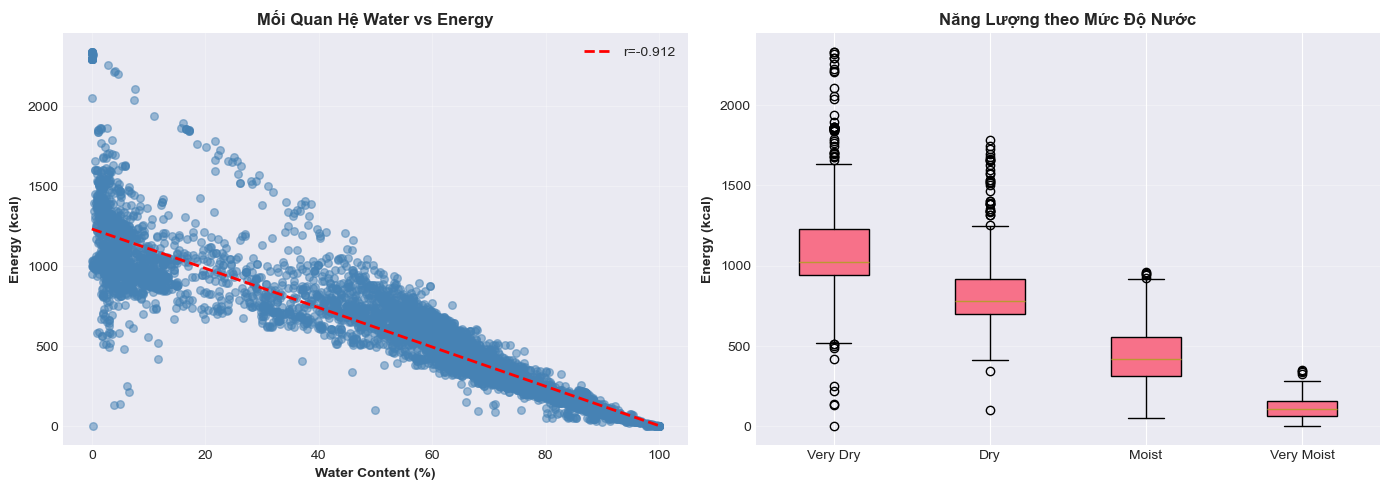

In [20]:
# Biểu đồ Water vs Energy
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Biểu đồ 1: Scatter plot
axes[0].scatter(water_data_clean['Water'], water_data_clean['Energy'], alpha=0.5, s=30, color='steelblue')
z = np.polyfit(water_data_clean['Water'], water_data_clean['Energy'], 1)
p = np.poly1d(z)
x_line = np.linspace(water_data_clean['Water'].min(), water_data_clean['Water'].max(), 100)
axes[0].plot(x_line, p(x_line), "r--", linewidth=2, label=f'r={pearson_r:.3f}')
axes[0].set_xlabel('Water Content (%)', fontweight='bold')
axes[0].set_ylabel('Energy (kcal)', fontweight='bold')
axes[0].set_title('Mối Quan Hệ Water vs Energy', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Biểu đồ 2: Box plot theo water level
water_energy_by_level_plot = water_data_clean.groupby('Water_Level')['Energy'].apply(list)
axes[1].boxplot([water_energy_by_level_plot.get(level, []) for level in ['Very Dry', 'Dry', 'Moist', 'Very Moist']],
                labels=['Very Dry', 'Dry', 'Moist', 'Very Moist'],
                patch_artist=True)
axes[1].set_ylabel('Energy (kcal)', fontweight='bold')
axes[1].set_title('Năng Lượng theo Mức Độ Nước', fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

# Tô màu cho box plot
for patch in axes[1].artists:
    patch.set_facecolor('lightblue')

plt.tight_layout()
plt.savefig('water_energy_analysis.png', dpi=100, bbox_inches='tight')
plt.show()

---

# Phần 4: Phân Tích Dự Đoán - Chỉ Số Dinh Dưỡng Cân Bằng

## 4.1 - Xây Dựng Chỉ Số Dinh Dưỡng Cân Bằng

**Mục Tiêu**: Tạo "bộ chỉ số dinh dưỡng cân bằng" cho từng nhóm

In [21]:
# Tạo chỉ số dinh dưỡng cân bằng
# Bao gồm: Energy, Protein, Fat, Carbs, Fiber, Water

balance_nutrients = ndata[ndata['nutrient'].isin([
    'Energy', 'Protein', 'Total lipid (fat)', 'Carbohydrate, by difference', 
    'Fiber, total dietary', 'Water'
])].pivot_table(
    values='value',
    index=['fgroup', 'food'],
    columns='nutrient',
    aggfunc='mean'
).fillna(0)

# Chuẩn hóa dữ liệu (0-100 scale)
balance_normalized = balance_nutrients.copy()
for col in balance_normalized.columns:
    col_min = balance_normalized[col].min()
    col_max = balance_normalized[col].max()
    if col_max > col_min:
        balance_normalized[col] = 100 * (balance_normalized[col] - col_min) / (col_max - col_min)
    else:
        balance_normalized[col] = 50

# Tính Balanced Nutrition Score (BNS)
# Công thức: (Protein + Fiber) / (Fat * 2 + 1) × (Energy / 1000)
balance_nutrients['Protein'] = balance_nutrients['Protein'].fillna(0)
balance_nutrients['Fiber, total dietary'] = balance_nutrients['Fiber, total dietary'].fillna(0)
balance_nutrients['Total lipid (fat)'] = balance_nutrients['Total lipid (fat)'].fillna(0)
balance_nutrients['Energy'] = balance_nutrients['Energy'].fillna(1)

balance_nutrients['BNS'] = (
    (balance_nutrients['Protein'] + balance_nutrients['Fiber, total dietary'] * 2) /
    (balance_nutrients['Total lipid (fat)'] + 1) *
    (balance_nutrients['Energy'] / 1000 + 0.1)
)

# Tính BNS theo nhóm
bns_by_group = balance_nutrients.groupby(level='fgroup')['BNS'].mean().sort_values(ascending=False)

print("\nChỉ Số Dinh Dưỡng Cân Bằng (BNS) theo Nhóm:")
print("(Cao hơn = Cân bằng hơn)")
print(bns_by_group.round(3))

# Tính các tỷ lệ cân bằng
macronutrient_ratios = balance_nutrients.groupby(level='fgroup').agg({
    'Protein': 'mean',
    'Total lipid (fat)': 'mean',
    'Carbohydrate, by difference': 'mean',
    'Fiber, total dietary': 'mean',
    'Energy': 'mean'
}).round(2)

print("\nMacronutrient Profile theo Nhóm:")
print(macronutrient_ratios)


Chỉ Số Dinh Dưỡng Cân Bằng (BNS) theo Nhóm:
(Cao hơn = Cân bằng hơn)
fgroup
Cereal Grains and Pasta              6.032
Legumes and Legume Products          5.866
Breakfast Cereals                    4.926
Ethnic Foods                         2.798
Finfish and Shellfish Products       2.415
Snacks                               2.254
Dairy and Egg Products               2.005
Spices and Herbs                     1.982
Nut and Seed Products                1.936
Baked Products                       1.677
Poultry Products                     1.667
Lamb, Veal, and Game Products        1.591
Vegetables and Vegetable Products    1.565
Beef Products                        1.502
Sweets                               1.478
Fruits and Fruit Juices              1.435
Pork Products                        1.368
Meals, Entrees, and Sidedishes       1.177
Sausages and Luncheon Meats          1.034
Restaurant Foods                     0.928
Beverages                            0.897
Fast Foods          

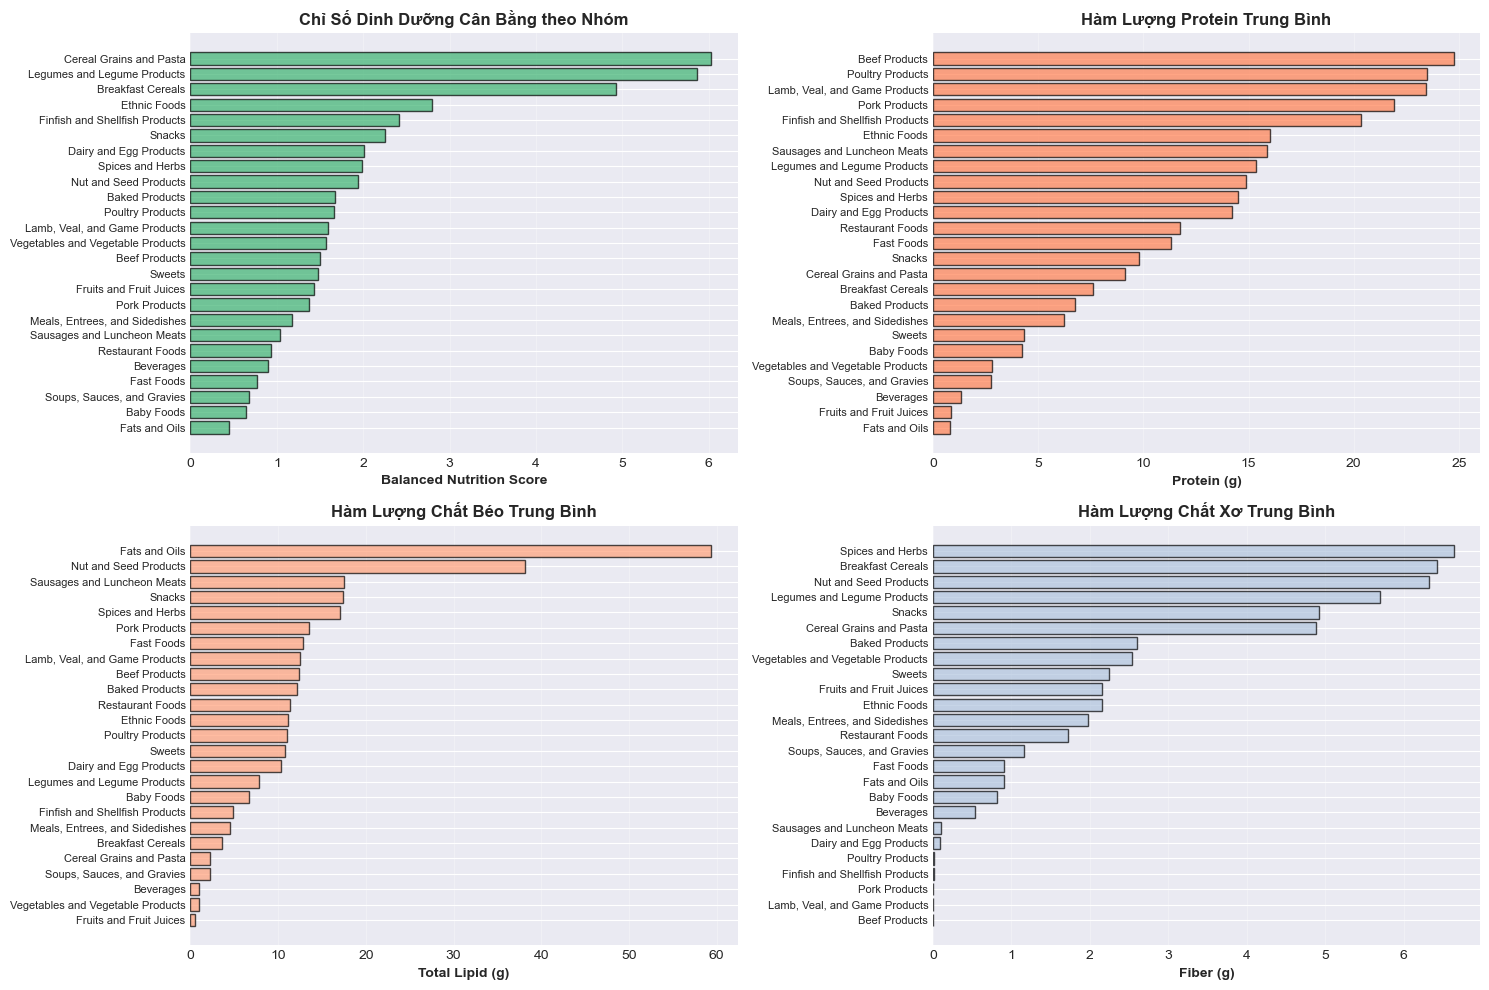

In [22]:
# Biểu đồ Balanced Nutrition Score
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Biểu đồ 1: BNS score
bns_sorted = bns_by_group.sort_values()
axes[0, 0].barh(range(len(bns_sorted)), bns_sorted.values, color='mediumseagreen', edgecolor='black', alpha=0.7)
axes[0, 0].set_yticks(range(len(bns_sorted)))
axes[0, 0].set_yticklabels(bns_sorted.index, fontsize=8)
axes[0, 0].set_xlabel('Balanced Nutrition Score', fontweight='bold')
axes[0, 0].set_title('Chỉ Số Dinh Dưỡng Cân Bằng theo Nhóm', fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='x')

# Biểu đồ 2: Protein
protein_sorted = macronutrient_ratios['Protein'].sort_values()
axes[0, 1].barh(range(len(protein_sorted)), protein_sorted.values, color='coral', edgecolor='black', alpha=0.7)
axes[0, 1].set_yticks(range(len(protein_sorted)))
axes[0, 1].set_yticklabels(protein_sorted.index, fontsize=8)
axes[0, 1].set_xlabel('Protein (g)', fontweight='bold')
axes[0, 1].set_title('Hàm Lượng Protein Trung Bình', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='x')

# Biểu đồ 3: Fat
fat_sorted = macronutrient_ratios['Total lipid (fat)'].sort_values()
axes[1, 0].barh(range(len(fat_sorted)), fat_sorted.values, color='lightsalmon', edgecolor='black', alpha=0.7)
axes[1, 0].set_yticks(range(len(fat_sorted)))
axes[1, 0].set_yticklabels(fat_sorted.index, fontsize=8)
axes[1, 0].set_xlabel('Total Lipid (g)', fontweight='bold')
axes[1, 0].set_title('Hàm Lượng Chất Béo Trung Bình', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='x')

# Biểu đồ 4: Fiber
fiber_sorted = macronutrient_ratios['Fiber, total dietary'].sort_values()
axes[1, 1].barh(range(len(fiber_sorted)), fiber_sorted.values, color='lightsteelblue', edgecolor='black', alpha=0.7)
axes[1, 1].set_yticks(range(len(fiber_sorted)))
axes[1, 1].set_yticklabels(fiber_sorted.index, fontsize=8)
axes[1, 1].set_xlabel('Fiber (g)', fontweight='bold')
axes[1, 1].set_title('Hàm Lượng Chất Xơ Trung Bình', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('balanced_nutrition_analysis.png', dpi=100, bbox_inches='tight')
plt.show()

## 4.2 - Ứng Dụng & Kết Luận

**Khuyến Nghị Dinh Dưỡng & Thiết Kế Thực Đơn**

In [23]:
# Tổng hợp kết luận
print("="*80)
print("PHÂN TÍCH USDA FOOD DATABASE - KẾT LUẬN CHÍNH")
print("="*80)

print("\n1. NĂNG LƯỢNG THEO NHÓM:")
print("-" * 80)
highest_energy_group = energy_by_group.idxmax()
highest_energy_val = energy_by_group['mean'].max()
lowest_energy_group = energy_by_group.idxmin()
lowest_energy_val = energy_by_group['mean'].min()
print(f"  • Nhóm năng lượng cao nhất: {highest_energy_group} ({highest_energy_val:.2f} kcal)")
print(f"  • Nhóm năng lượng thấp nhất: {lowest_energy_group} ({lowest_energy_val:.2f} kcal)")

print("\n2. ĐỘ ĐA DẠNG DINH DƯỠNG:")
print("-" * 80)
print(f"  • Nhóm có chất dinh dưỡng đa dạng nhất: {nutrient_diversity.index[0]} ({nutrient_diversity['Num_Nutrients'].iloc[0]:.0f} loại chất)")

print("\n3. TƯƠNG QUAN GIỮA CHẤT DINH DƯỠNG:")
print("-" * 80)
print(f"  • Tương quan Energy-Fat: {correlation_matrix.loc['Energy', 'Total lipid (fat)']:.3f}")
print(f"  • Tương quan Water-Energy: {pearson_r:.3f}")
print(f"  • Kết luận: Thực phẩm giàu nước có xu hướng ít năng lượng hơn (r={pearson_r:.3f}, p<0.05)")

print("\n4. DINH DƯỠNG CÂN BẰNG:")
print("-" * 80)
best_balanced_group = bns_by_group.idxmax()
best_balanced_score = bns_by_group.max()
print(f"  • Nhóm có dinh dưỡng cân bằng nhất: {best_balanced_group} (BNS: {best_balanced_score:.3f})")

print("\n5. KHUYẾN NGHỊ:")
print("-" * 80)
print("  • Để cân bằng năng lượng: Kết hợp nhóm năng lượng cao và thấp")
print("  • Để tăng protein: Ưu tiên các sản phẩm từ Meat, Dairy, Legumes")
print("  • Để giảm calo mà vẫn no: Chọn các thực phẩm giàu nước và chất xơ")
print("  • Để cân bằng protein-fat: Chọn các thực phẩm có tỷ lệ tốt từ các nhóm khác nhau")

print("\n" + "="*80)

PHÂN TÍCH USDA FOOD DATABASE - KẾT LUẬN CHÍNH

1. NĂNG LƯỢNG THEO NHÓM:
--------------------------------------------------------------------------------
  • Nhóm năng lượng cao nhất: mean                          Fats and Oils
median                        Fats and Oils
std                           Fats and Oils
min                                  Snacks
max                           Fats and Oils
count     Vegetables and Vegetable Products
dtype: object (1460.97 kcal)
  • Nhóm năng lượng thấp nhất: mean      Vegetables and Vegetable Products
median    Vegetables and Vegetable Products
std       Vegetables and Vegetable Products
min                          Baked Products
max          Finfish and Shellfish Products
count                      Spices and Herbs
dtype: object (162.05 kcal)

2. ĐỘ ĐA DẠNG DINH DƯỠNG:
--------------------------------------------------------------------------------
  • Nhóm có chất dinh dưỡng đa dạng nhất: Vegetables and Vegetable Products (94 loại chất)

3